<a href="https://colab.research.google.com/github/jagdishgg/CNN-Transfer-learning-Pneumonia-detection/blob/main/Gesture_Recognisation_Jagdish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
from skimage import transform  
import datetime
import os
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [3]:
import os
from google.colab import files

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!pwd

/content


In [7]:
!dir

gdrive	sample_data


In [8]:
os.chdir('/content/gdrive/MyDrive/kaggle')

In [9]:
!dir

Jagdish_Galipelli_nn.ipynb  Project_data  Project_data.zip


In [8]:
## Commented for rerun 
## !unzip   '/content/gdrive/MyDrive/kaggle/Project_data.zip' 

In [10]:
os.chdir('/content/gdrive/MyDrive/kaggle/Project_data/')

In [11]:
!dir

model_init_2022-08-1306_41_22.779367  model_init_2022-08-1312_43_29.304673
model_init_2022-08-1306_48_11.127302  model_init_2022-08-1315_22_15.526469
model_init_2022-08-1306_49_34.748519  model_init_2022-08-1315_24_41.541112
model_init_2022-08-1306_57_23.044073  model_init_2022-08-1315_25_47.585725
model_init_2022-08-1308_30_12.901750  model_init_2022-08-1315_26_53.912604
model_init_2022-08-1311_40_02.261797  model_init_2022-08-1315_36_58.490591
model_init_2022-08-1312_19_16.113967  model_init_2022-08-1317_51_12.873985
model_init_2022-08-1312_20_17.333752  model_init_2022-08-1318_03_20.389719
model_init_2022-08-1312_21_27.132343  model_init_2022-08-1319_07_27.406416
model_init_2022-08-1312_36_09.180633  train
model_init_2022-08-1312_37_00.837183  train.csv
model_init_2022-08-1312_37_37.419192  val
model_init_2022-08-1312_38_30.742518  val\ (1).csv
model_init_2022-08-1312_40_09.151104  val.csv
model_init_2022-08-1312_41_01.455826


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [12]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/kaggle/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/kaggle/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

image_ht=100
image_wdt=100
channels=3

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:
def  batchprocess(source_path,t,batch,batch_size,img_idx,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),image_ht,image_wdt,channels)) 
        batch_labels = np.zeros((seq_len,num_classes))    
        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
          
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                size=(image_ht,image_wdt)
                image_resized=cv2.resize(image, size)          
                batch_data[folder,idx,:,:,0] =(image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1          
        return(batch_data,batch_labels)

In [14]:

def generator(source_path, folder_list, batch_size,augment = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = np.round(np.linspace(0,29,20)).astype(int)  
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches =  len(t)//batch_size
        for batch in range(num_batches): 
                batch_data, batch_labels= batchprocess(source_path,t,batch,batch_size,img_idx)
                yield batch_data, batch_labels 

        remaining_seq=len(t)%batch_size
        
        if (remaining_seq != 0):
                batch_data, batch_labels= batchprocess(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
                yield batch_data, batch_labels       


Commenting below
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [0,2,4,6,8,10,12,14,16,18,20,22] #create a list of image numbers you want to use for a particular video
    img_idx = np.round(np.linspace(0,29,15)).astype(int)  
    x=len(img_idx)
    y=100
    z=100
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  ( len(t)//batch_size)  # calculate the number of batches
        rem_seq=len(t)%batch_size  # remaining sequences
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = image.resize((100, 100))
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =  batch_data[folder,idx,:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = batch_data[folder,idx,:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =  batch_data[folder,idx,:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if rem_seq!=0:
          for batch in range(rem_seq): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = image.resize((100, 100))
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =  batch_data[folder,idx,:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = batch_data[folder,idx,:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =  batch_data[folder,idx,:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
          


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/kaggle/Project_data/train'
val_path = '/content/gdrive/MyDrive/kaggle/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
num_classes=5
print ('# num_classes =', num_classes)

# training sequences = 663
# validation sequences = 100
# epochs = 15
# num_classes = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers

from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [16]:
#write your model here

model = Sequential()
#-----------------------------------------------------
model.add(Conv3D(32, (3, 3, 3), padding='same',input_shape=(20,image_ht,image_wdt,channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size= (2, 2, 2)))

#-----------------------------------------------------
model.add(Conv3D(32,  (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size= (2, 2, 2)))
#-----------------------------------------------------
model.add(Conv3D(64,  (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size= (2, 2, 2)))
#-----------------------------------------------------
model.add(Conv3D(64,  (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size= (2, 2, 2)))
#-----------------------------------------------------
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_classes,activation='softmax'))


## commented out 

#-----------------------------
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(100, 100,12, 3)))
model.add(Conv3D(32, (3, 3,3), padding='same',
                 input_shape=(3, 3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
optimiser = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 100, 100, 32)  2624      
                                                                 
 activation (Activation)     (None, 20, 100, 100, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 100, 100, 32)  8224      
                                                                 
 activation_1 (Activation)   (None, 20, 100, 100, 32)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 100, 100, 32)  128      
 hNormalization)                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 25,670,373
Trainable params: 25,669,605
Non-trainable params: 768
_________________________________________________________________
None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
# Sample
sample_generator = generator(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)



Source path =  /content/gdrive/MyDrive/kaggle/Project_data/train ; batch size = 30
(30, 20, 120, 120, 3)


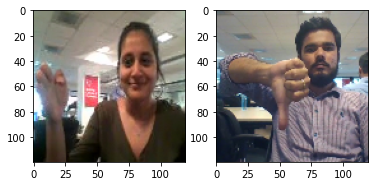

In [30]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_batch_data[25,10,:,:,:])
plt.show()

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='loss',
                                   factor=0.1,
                                   cooldown=0,
                                   patience=5,
                                   min_lr=1e-4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print('steps_per_epoch',steps_per_epoch)
print('validation_steps',validation_steps)


steps_per_epoch 23
validation_steps 4


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history =model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/gdrive/MyDrive/kaggle/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.0741 - categorical_accuracy: 0.3032  Source path =  /content/gdrive/MyDrive/kaggle/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-08-1315_36_58.490591/model-00001-2.07413-0.30317-7803.01514-0.21000.h5
23/23 [==============================] - 3694s 168s/step - loss: 2.0741 - categorical_accuracy: 0.3032 - val_loss: 7803.0151 - val_categorical_accuracy: 0.2100 - lr: 0.2000
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.5786 - categorical_accuracy: 0.3439
Epoch 2: saving model to model_init_2022-08-1315_36_58.490591/model-00002-1.57856-0.34389-110.11201-0.18000.h5
23/23 [==============================] - 67s 3s/step - loss: 1.5786 - categorical_accuracy: 0.3439 - val_loss: 110.1120 - val_categorical_accuracy: 0.1800 - lr: 0.2000
Epoch 3/15
23/23 [==============================] - ETA: 0

In [25]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

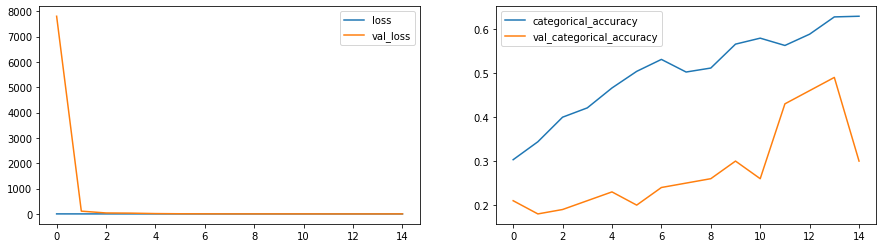

In [ ]:
plot(history)

In [28]:
num_epochs = 10
batch_size = 30 #experiment with the batch size

image_ht=120
image_wdt=120
channels=3
kernelsize=(3,3,3)

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [33]:

model2 = Sequential()
#-----------------------------------------------------
model2.add(Conv3D(128, kernelsize, padding='same',input_shape=(20,image_ht,image_wdt,channels)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
#model2.add(MaxPooling3D(pool_size= kernelsize))

#-----------------------------------------------------
model2.add(Conv3D(64,  kernelsize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
#model2.add(MaxPooling3D(pool_size=kernelsize))
#-----------------------------------------------------
model2.add(Conv3D(64, kernelsize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=kernelsize))
#-----------------------------------------------------
model2.add(Conv3D(64, kernelsize, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=kernelsize))
#-----------------------------------------------------
model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(num_classes,activation='softmax'))

In [34]:
optimiser = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01) 
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 120, 120, 128  10496     
                             )                                   
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 128  0         
                             )                                   
                                                                 
 batch_normalization_15 (Bat  (None, 20, 120, 120, 128  512      
 chNormalization)            )                                   
                                                                 
 conv3d_7 (Conv3D)           (None, 20, 120, 120, 64)  221248    
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 64)  0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [35]:
history2 =model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/gdrive/MyDrive/kaggle/Project_data/train ; batch size = 30
Epoch 1/10


ResourceExhaustedError: ignored

In [35]:
model_4 = Sequential()

model_4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(20,image_ht,image_wdt,channels)))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4.add(TimeDistributed(Flatten()))


model_4.add(LSTM(128))
model_4.add(Dropout(0.3))
        
model_4.add(Dense(128,activation='relu'))
model_4.add(Dropout(0.3))
        
model_4.add(Dense(num_classes, activation='softmax'))
optimiser = tf.optimizers.Adam()
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [36]:
optimiser = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01) 
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 60, 60, 32)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [37]:
history4 =model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.6015 - categorical_accuracy: 0.2624  Source path =  /content/gdrive/MyDrive/kaggle/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-08-1319_07_27.406416/model-00001-1.60153-0.26244-1.84309-0.27000.h5
23/23 [==============================] - 8004s 364s/step - loss: 1.6015 - categorical_accuracy: 0.2624 - val_loss: 1.8431 - val_categorical_accuracy: 0.2700 - lr: 0.2000
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.5180 - categorical_accuracy: 0.3544
Epoch 2: saving model to model_init_2022-08-1319_07_27.406416/model-00002-1.51795-0.35445-1.78155-0.16000.h5
23/23 [==============================] - 73s 3s/step - loss: 1.5180 - categorical_accuracy: 0.3544 - val_loss: 1.7815 - val_categorical_accuracy: 0.1600 - lr: 0.2000
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.3957 - categorical_accuracy: 0.3831
Epoch 3: saving model to model_init_2022-08-1

In [ ]:
num_epochs = 25

In [19]:
model_5 = Sequential()

model_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(20,image_ht,image_wdt,channels)))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Flatten()))


model_5.add(LSTM(128))
model_5.add(Dropout(0.3))
        
model_5.add(Dense(128,activation='relu'))
model_5.add(Dropout(0.3))
        
model_5.add(Dense(num_classes, activation='softmax'))
optimiser = tf.optimizers.Adam()
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [20]:
optimiser = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01) 
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 64)  1792     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 64)  256      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 64)   36928     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 64)   2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Trainable params: 528,261
Non-trainable params: 640
_________________________________________________________________
None


In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
history5 =model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/gdrive/MyDrive/kaggle/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.5150 - categorical_accuracy: 0.3394  Source path =  /content/gdrive/MyDrive/kaggle/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-08-1404_58_05.377837/model-00001-1.51498-0.33937-2.04615-0.22000.h5
23/23 [==============================] - 3365s 152s/step - loss: 1.5150 - categorical_accuracy: 0.3394 - val_loss: 2.0461 - val_categorical_accuracy: 0.2200 - lr: 0.2000
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.3890 - categorical_accuracy: 0.3952
Epoch 2: saving model to model_init_2022-08-1404_58_05.377837/model-00002-1.38901-0.39517-2.63064-0.22000.h5
23/23 [==============================] - 69s 3s/step - loss: 1.3890 - categorical_accuracy: 0.3952 - val_loss: 2.6306 - val_categorical_accuracy: 0.2200 - lr: 0.2000
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 

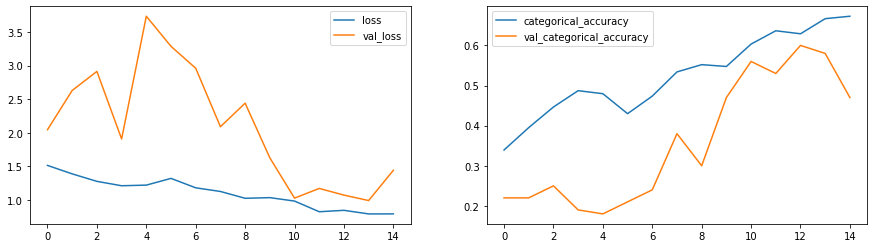

In [26]:
plot(history5)